# Polynomial example

In [1]:
import numpy as np
import tensorflow as tf
from bayesmodels.core_models import BayesianGP
import tensorflow_probability as tfp
import math 
from pyDOE import lhs
from tensorflow_probability.python import distributions  as tfd

In [2]:
def p(X):
    return (3*X[:,0]**2 + 1)*(3*X[:,1]**2 + 1)/4

In [3]:
# Generating input and output training data
Xtrain = lhs(2, 400)
print(Xtrain.shape)

Ytrain = p(Xtrain)
print(Ytrain.shape)

(400, 2)
(400,)


In [4]:
# Normalizing the training data 
mean_x = np.mean(Xtrain, axis = 0)
std_x = np.std(Xtrain, axis = 0, keepdims = True)
Xnorm = (Xtrain - mean_x)/std_x
mean_y = np.mean(Ytrain)
std_y = np.std(Ytrain)
Ynorm= (Ytrain - mean_y)/std_y
scaling =[[mean_x, std_x],[mean_y, std_y]]

## Fitting a Gaussian process

In [5]:
noise_level = 5e-4
name = 'test_model'
kernel_type = 'RBF'

model = BayesianGP(inputs = Xnorm, outputs = Ynorm,
                kernel_type= kernel_type, noise_level = noise_level, name = name)

In [6]:
new_vark_prior = tfd.Gamma(concentration = 15.0, rate = 15.0, name = name + '/rv_vark')
model.update_prior('test_model/kernel/vark', new_vark_prior)

In [7]:
# Executing mcmc smapling 
mcmc_samples = 6000
num_burnin_steps = 8000
num_adaptation_steps = 4000
adaption_rate = 0.50
init_step_size = 0.15
num_leapfrog_steps = 3
thinning = 1

hyp_samples, average_acceptane_ratio = model.mcmc(mcmc_samples, num_burnin_steps,
                                                 num_adaptation_steps,
                                                adaption_rate,
                                                init_step_size,
                                                num_leapfrog_steps,
                                                thinning)

print('Average acceptance ratio: ', average_acceptane_ratio.numpy())

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Average acceptance ratio:  0.64629817


In [8]:
import matplotlib.pyplot as plt

(6000, 2)


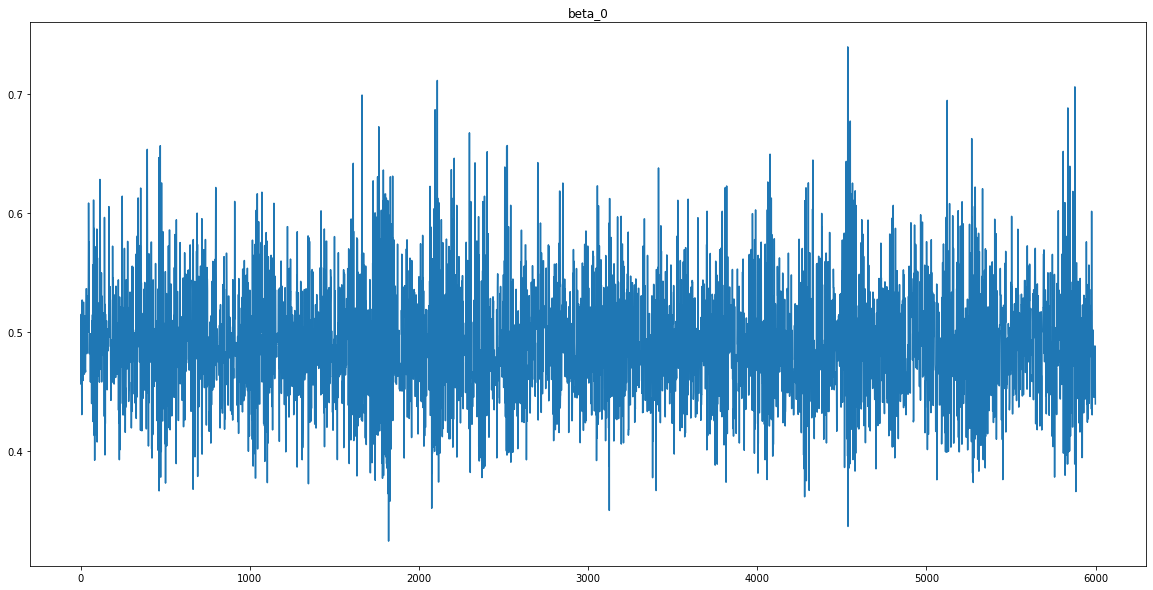

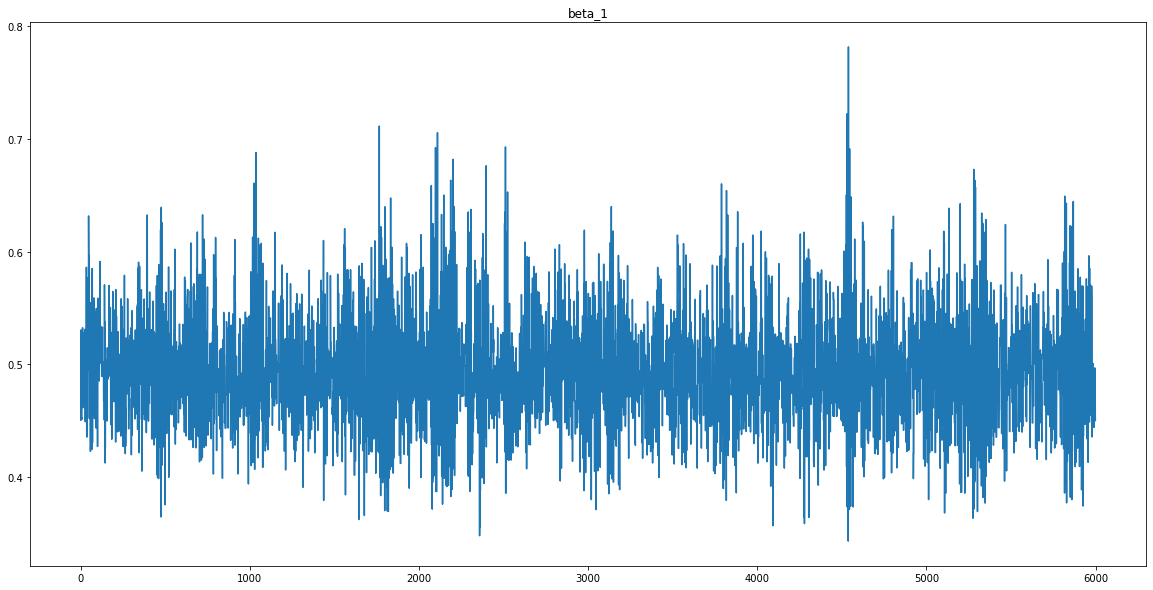

In [9]:
beta_samples= hyp_samples[0].numpy()
print(beta_samples.shape)

for i in range(2):
    plt.figure(figsize=(20,10))
    plt.plot(beta_samples[:,i])
    title = 'beta_' + str(i)
    plt.title(title)

In [10]:
vark_samples = hyp_samples[1].numpy()
plt.figure(figsize=(20,10))
plt.plot(vark_samples)
title = 'vark'
plt.title(title)

Text(0.5, 1.0, 'vark')

## Sensitivity analysis 

In [11]:
from bayesmodels.sensitivity import sensitivity
from bayesmodels.sensitivity import sampling
from bayesmodels.sensitivity import labelling

### Main effect functions

In [12]:
# Theoretical values
def z_th(x):
    return (3*x**2 + 1)/2 -1

In [13]:
from bayesmodels.sensitivity import sensitivity

In [14]:
selected_vars = [0,1]

In [16]:
grid_points = 50
nx_samples = 7000
bounds = np.zeros((2,2))
bounds[:,0] = np.min(Xnorm, axis = 0)
bounds[:,1] = np.max(Xnorm, axis = 0)

hyps = []
for i in range(3):
    hyps.append(tfp.stats.percentile(hyp_samples[i], 50, axis = 0))

In [17]:
# compute marginalization 
Zmain = sensitivity.get_maineffectGP(model, hyps, bounds, selected_vars, grid_points, nx_samples)

In [18]:
print(Zmain.keys())

dict_keys([(0,), (1,)])


In [19]:
temp = sensitivity.get_fullmarginal_posteriorGP(model, hyps, bounds, nx_samples, reduced = False)
print(temp)

{'grid_points': [], 'mean': array([[0.0094811]], dtype=float32), 'var': array([[1.e-12]], dtype=float32)}


In [20]:
e_y = std_y*temp['mean'][0,0] + mean_y
print(e_y)

0.9958917806139318


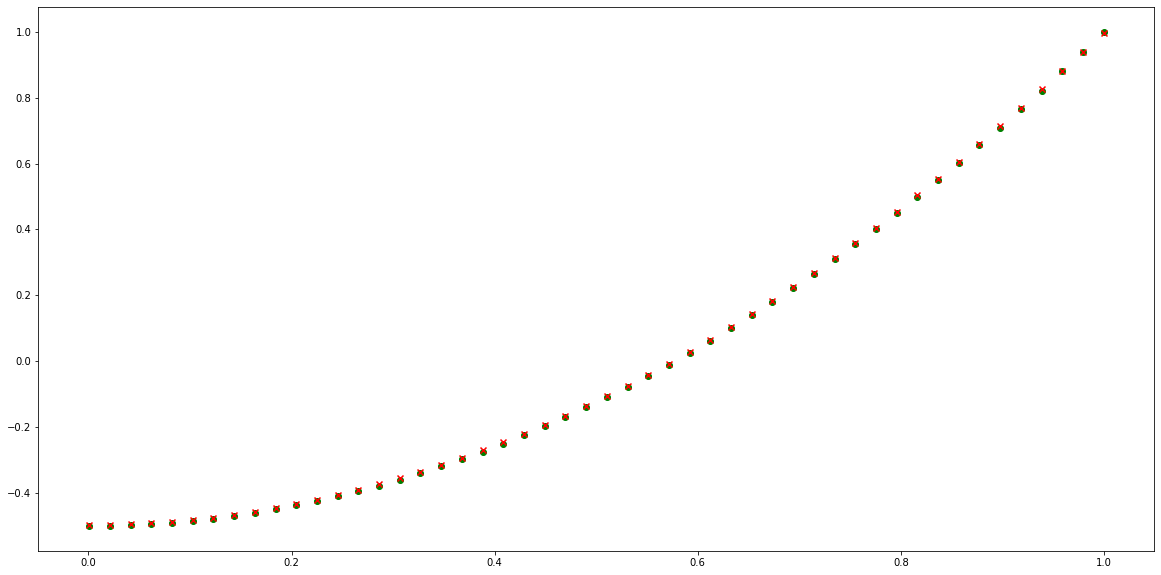

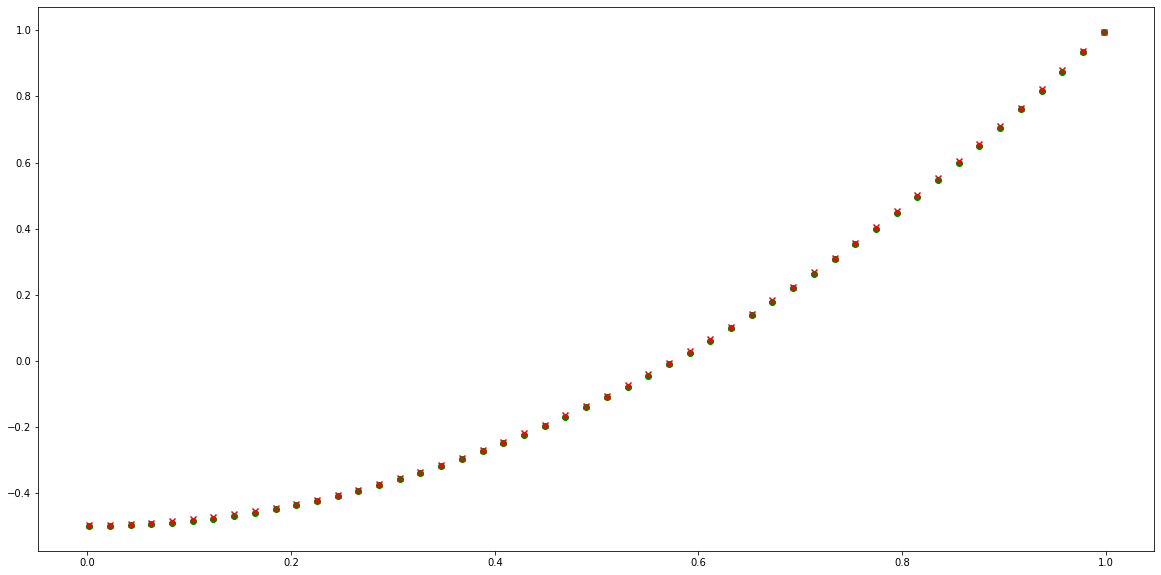

In [21]:
for i in range(2):
    key = tuple([i])
    x = Zmain[key]['grid_points'][:,0]
    x = x*std_x[:,i] + mean_x[i]
    z_main = Zmain[key]['mean'][:,0]
    z_main= z_main*std_y + mean_y
    z_main -= e_y
    z_mainth = z_th(x)
    plt.figure(figsize=(20,10))
    plt.scatter(x, z_mainth, marker ='o', color = 'green')
    plt.scatter(x, z_main, marker= 'x', color = 'red')
   

### Sobol indices

In [22]:
S = [i for i in range(2)]
subsets_list = labelling.powerset(S, 1, 1)

In [23]:
# compute marginalization 
Vmarg = sensitivity.get_marginal_posteriorGP(model, hyps, bounds, subsets_list, grid_points, nx_samples)

In [24]:
# full sampling 
Vfull = sensitivity.get_full_posteriorGP(model, hyps, bounds, nx_samples)

In [25]:
print(Vfull)

1.0814375


In [26]:
V_fullmarg = sensitivity.get_fullmarginal_posteriorGP(model, hyps, bounds, nx_samples)

In [27]:
e0 = V_fullmarg
print(e0)

0.00012791315


In [28]:
def compute_Sobol(S,V, V_fullmarg, Vfull, key):
    S[key] = (V[key] -V_fullmarg)/(Vfull -V_fullmarg)
    if len(key) > 1:
        subsets = sampling.powerset(list(key),1,len(key)-1)
        for item in subsets:
            S[key] -= S[tuple(item)]
    S[key] = np.maximum(S[key],0)
    return

In [29]:
sobol ={}
for i in range(len(subsets_list)):
    key = tuple(subsets_list[i])
    compute_Sobol(sobol,Vmarg, V_fullmarg, Vfull, key)

In [30]:
sobol_true = 1/(5*(1.2**2-1))
print(sobol_true)

0.4545454545454546


In [31]:
for key in sobol.keys():
    print(key, sobol[key], sobol_true)

(0,) 0.45907163619995117 0.4545454545454546
(1,) 0.4506905972957611 0.4545454545454546
